## 캐글 따라하기 (kaggle_Bike Sharing Demand)

Reference:
     
  - 깃헙:[corazzon/KaggleStruggle](https://github.com/corazzon/KaggleStruggle/blob/master/bike-sharing-demand/bike-sharing-demand-rf.ipynb)

이번 블로그는 캐글에서 돌아다니는 bike sharing demand의 대해 날씨, 휴일, 평일, 계절 등등에 따라 변하는 bike sharing demand의 대한 데이터를 가지고 재구성 및 시각화를 해보려 한다.
앞으로 진행할 프로젝트의 최종 목표는 학습 데이터로 모델을 학습시킨 후 공공자전거의 수요량을 예측하는 것이다. 즉, 테스트 데이터 정보(features, 종속변수)를 바탕으로 제출용 데이터의 'count'(target, 독립변수)를 예측하는 것이다.

- 지도학습중에 분류와 회귀중 회귀와 관련 된 문제 => 자전거 대여량을 예측하는 문제이기 때문에
    - 캐글의 타이타닉 생존자 의 경우는 분류와 회귀 중에 분류에 속한다 => 생존여부를 가려내야 하는 문제이기 때문에

- 간략한 도메인 지식

워싱턴 D.C 소재의 자전거 대여 스타트업 회사인 Capital BikeShare의 데이터를 활용하여 특정 시간대에 얼마나 많은 사람들이 자전거를 대여하는지 예측하는 과제이다. 데이터 분석과 시각화, 머신 러닝 알고리즘을 이용하여 시간당 자전거 대여량을 예측할 예정입니다. 사람들이 자전거를 대여하는데는 많은 요소가 관여하고 있다. 예로는 새벽보다는 낮시간이 더 많을 것이고, 날씨에도 영향을 받아 비가오는 날에는 엄청 줄을 것이다.근무 시간보다는 여가시간에 자전거를 더 많이 대여할 것이다. 프로그래밍 지식, 인공 지능, 머신 러닝 지식을 제외하고, 자전거 렌탈 시장에 대한 도메인지식과 우리가 자전거를 탔을때의 경험과 기초상식 등을 총 동원해서 효율적인 예측을 해보자.



#### 분석 및 예측에 사용된 라이브러리

- Juppter Notebook: 웹 브라우저 기반 편집 환경
- Python: 쉽고 명확한 범용적 프로그래밍 언어
- Pandas: Python 기반의 데이터 분석 및 처리 라이브러리
- Numpy: Python 기반의 쉽고 빠른 과학 연산 라이브러리
- Seaborn: Python 기반의 시각화 라이브러리
- Scikit-Learn: Python 기반의 머신러닝 관련 라이브러리
- XGBoost: 학습에 사용될 Gradient Boosting 알고리즘이 구현된 라이브러리

 #### Column 종류 및 설명
 
- datetime: 년-월-일 시간 데이터
- season: 1 = 봄, 2 = 여름, 3 = 가을, 4 = 겨울
- holiday: 공휴일 또는 주말
- workingday: 공휴일, 주말을 제외한 평일
- weather
    - 1: 매우 맑음(Clear, Few clouds, Partly cloudy, Partly cloudy)
    - 2: 맑음(Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist)
    - 3: 나쁨(Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds)
- 4: 매우 나쁨(Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog)
- temp: 기온
- atemp: 체감온도 정도로 보자
- humidity: 상대 습도
- windspeed: 바람의 세기
- casual: 미등록 사용자 렌탈 수
- registered: 등록된 사용자 렌탈수
- count: 렌탈한 총 합

In [2]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 노트북 안에 그래프를 그리기 위해
%matplotlib inline

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

In [3]:
# 한글폰트
import platform

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
    print('Mac version')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
    print('Windows version')
elif platform.system() == 'Linux':
    path = "/usr/share/fonts/NanumFont/NanumGothicBold.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    plt.rc('font', family=font_name)
    print('Linux version')
else:
    print('Unknown system... sorry~~~~')

Linux version


#### Step 1. Data Load 

In [4]:
# 판다스의 read_csv로 train.csv 파일 읽어오기

train = pd.read_csv('./kaggle_Bike Sharing Demand/train.csv',parse_dates=["datetime"])   # datetime형식으로 불러오기 parse_dates써서
test = pd.read_csv('./kaggle_Bike Sharing Demand/test.csv',parse_dates=["datetime"])

In [5]:
print(train.shape)   # 출력은 (row, column)으로 표시 된다.
train.head()   # head()로  train 데이터 상위 5개를 띄운다.

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


#### Step2 . 탐색적 데이터 분석 (train 데이터만)

datetime 형식과, float, int 형식으로 되어있는것을 볼 수 있다. trani.head()함수를써서 직접 눈으로 보자.

In [7]:
train.head(10)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
5,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1
6,2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0.0000,2,0,2
7,2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,0.0000,1,2,3
8,2011-01-01 08:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,7,8
9,2011-01-01 09:00:00,1,0,0,1,13.12,17.425,76,0.0000,8,6,14


- train.head(5)로 할때는 windspeed 가 0으로만 되어있어서, 좀더 보기 위해 10,20 으로 늘려보니 0으로 되어있는 값은 결측치를 0으로 채운것 같다.
- 0으로 되어있는 것을 어떻게 피처엔지니어링 하는것에 따라서 점수가 다르게 나올 것 같다.

In [8]:
train.temp.describe()

count    10886.00000
mean        20.23086
std          7.79159
min          0.82000
25%         13.94000
50%         20.50000
75%         26.24000
max         41.00000
Name: temp, dtype: float64

- 평균 기온은 20.23도 정도 되는 것을 확인 할 수 있다.

In [9]:
# train 데이터에서 결측치 있는지 확인하기

train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

- train에서 null인 데이터는 없다.

<AxesSubplot:>

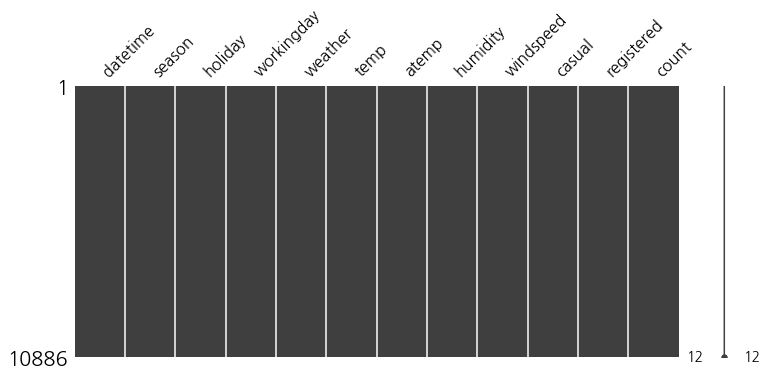

In [10]:
# 결측치가 있는지 확인 해 볼수있는 시각화 tool
import missingno as msno

msno.matrix(train, figsize=(12,5))

datetime으로 되어있는 데이터를 좀 더 나누어서 보자.
(년)year,(월)month,(일)day,(시간)hour,(분)minute,(초)second로 나누어 추가해보자.

In [11]:
train["year"] = train["datetime"].dt.year
train["month"] = train["datetime"].dt.month
train["day"] = train["datetime"].dt.day
train["hour"] = train["datetime"].dt.hour
train["minute"] = train["datetime"].dt.minute
train["second"] = train["datetime"].dt.second
train.shape

(10886, 18)

- column이 12개에서 18개로 늘어난 것을 확인 할 수 있다. train.head()로도 확인해보자.

In [12]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,0,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,0,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,0,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,0,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,0,0


위에서 datetime을  (년)year,(월)month,(일)day,(시간)hour,(분)minute,(초)second로 나누어 추가한 것을 borplot으로 시각화 해보자.

[Text(0.5, 0, 'hour'), Text(0.5, 1.0, '시간별 대여량')]

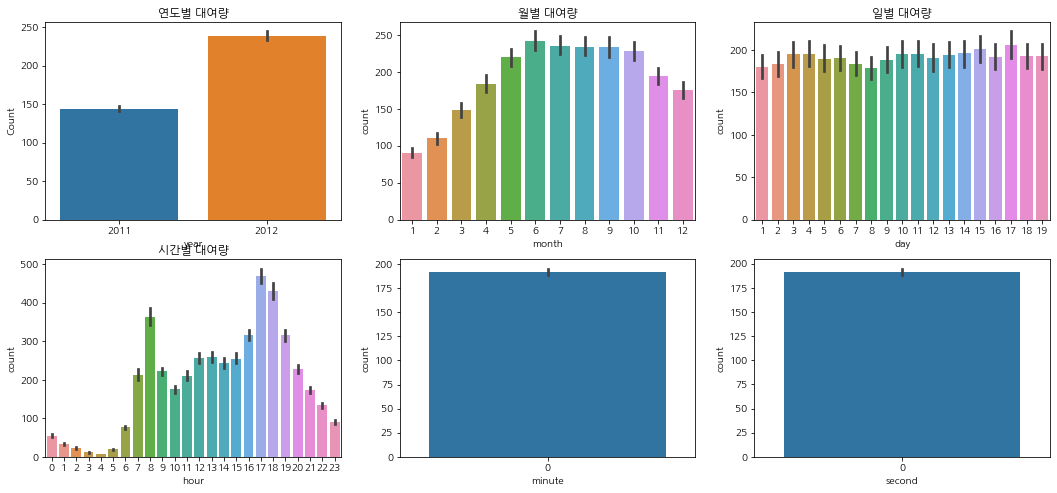

In [13]:
figure, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3)
figure.set_size_inches(18,8)

sns.barplot(data=train, x="year", y="count", ax=ax1)
sns.barplot(data=train, x="month", y="count", ax=ax2)
sns.barplot(data=train, x="day", y="count", ax=ax3)
sns.barplot(data=train, x="hour", y="count", ax=ax4)
sns.barplot(data=train, x="minute", y="count", ax=ax5)
sns.barplot(data=train, x="second", y="count", ax=ax6)

ax1.set(ylabel='Count',title="연도별 대여량")
ax2.set(xlabel='month',title="월별 대여량")
ax3.set(xlabel='day', title="일별 대여량")
ax4.set(xlabel='hour', title="시간별 대여량")

- 연도별 대여량은 2011년 보다 2012년이 더 많다.
- 월별 대여량은 6월에 가장 많고 7~10월도 대여량이 많다. 그리고 1월에 가장 적다.
- 일별대여량은 1일부터 19일까지만 있고 나머지 날짜는 test.csv에 있다. 그래서 이 데이터는 피처로 사용하면 안 된다.
- 시간 대 대여량을 보면 출퇴근 시간에 대여량이 많은 것 같다. 하지만 주말과 나누어 볼 필요가 있을 것 같다.
- 분, 초도 다 0이기 때문에 의미가 없다.

계절, 시간, 근무일 여부에 따라 bocplot으로 시각해 해보자.

[Text(0.5, 0, 'Working Day'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, '근무일 여부에 따른 대여량')]

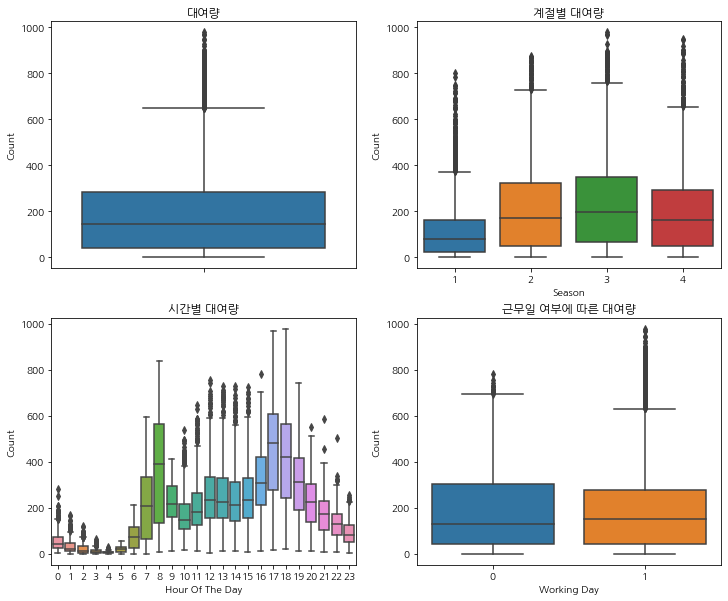

In [14]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
sns.boxplot(data=train,y="count",orient="v",ax=axes[0][0])
sns.boxplot(data=train,y="count",x="season",orient="v",ax=axes[0][1])
sns.boxplot(data=train,y="count",x="hour",orient="v",ax=axes[1][0])
sns.boxplot(data=train,y="count",x="workingday",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="대여량")
axes[0][1].set(xlabel='Season', ylabel='Count',title="계절별 대여량")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="시간별 대여량")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="근무일 여부에 따른 대여량")

- 대여량의 경우 특정구간에 몰려있는 것을 볼 수 있다.
- 봄(1),여름(2),가을(3),겨울(4) 인데, 가을 > 여름 > 겨울 > 봄 순으로 대여량이 많다.
- 시간대별 대여량은 barplot 와 비슷하게 나온것을 확인해 볼 수 있다.
- 근무일 여부에 따른 대여량 에서는 비슷은하지만, 휴일에 좀더 많은 대여량이 있는 것을 확인 할 수 있다.

dayofweek도 train 데이터 프레임에 담아봐서 한번 보도록하자.

In [15]:
train["dayofweek"] = train["datetime"].dt.dayofweek
train.shape

(10886, 19)

- 18개에서 19개로 데이터프레임 column이 늘은 것을 확인

In [16]:
train["dayofweek"].value_counts()

5    1584
6    1579
3    1553
2    1551
0    1551
1    1539
4    1529
Name: dayofweek, dtype: int64

- 0~6 : 월 화 수 목 금 토 일 인데, 요일별 큰차이는 없는 것을 확인 할 수 있다.

pointplot 으로 시간대별, 대여량을 worjingday, datofweek, weather, season 별로 확인해보자.

<AxesSubplot:xlabel='hour', ylabel='count'>

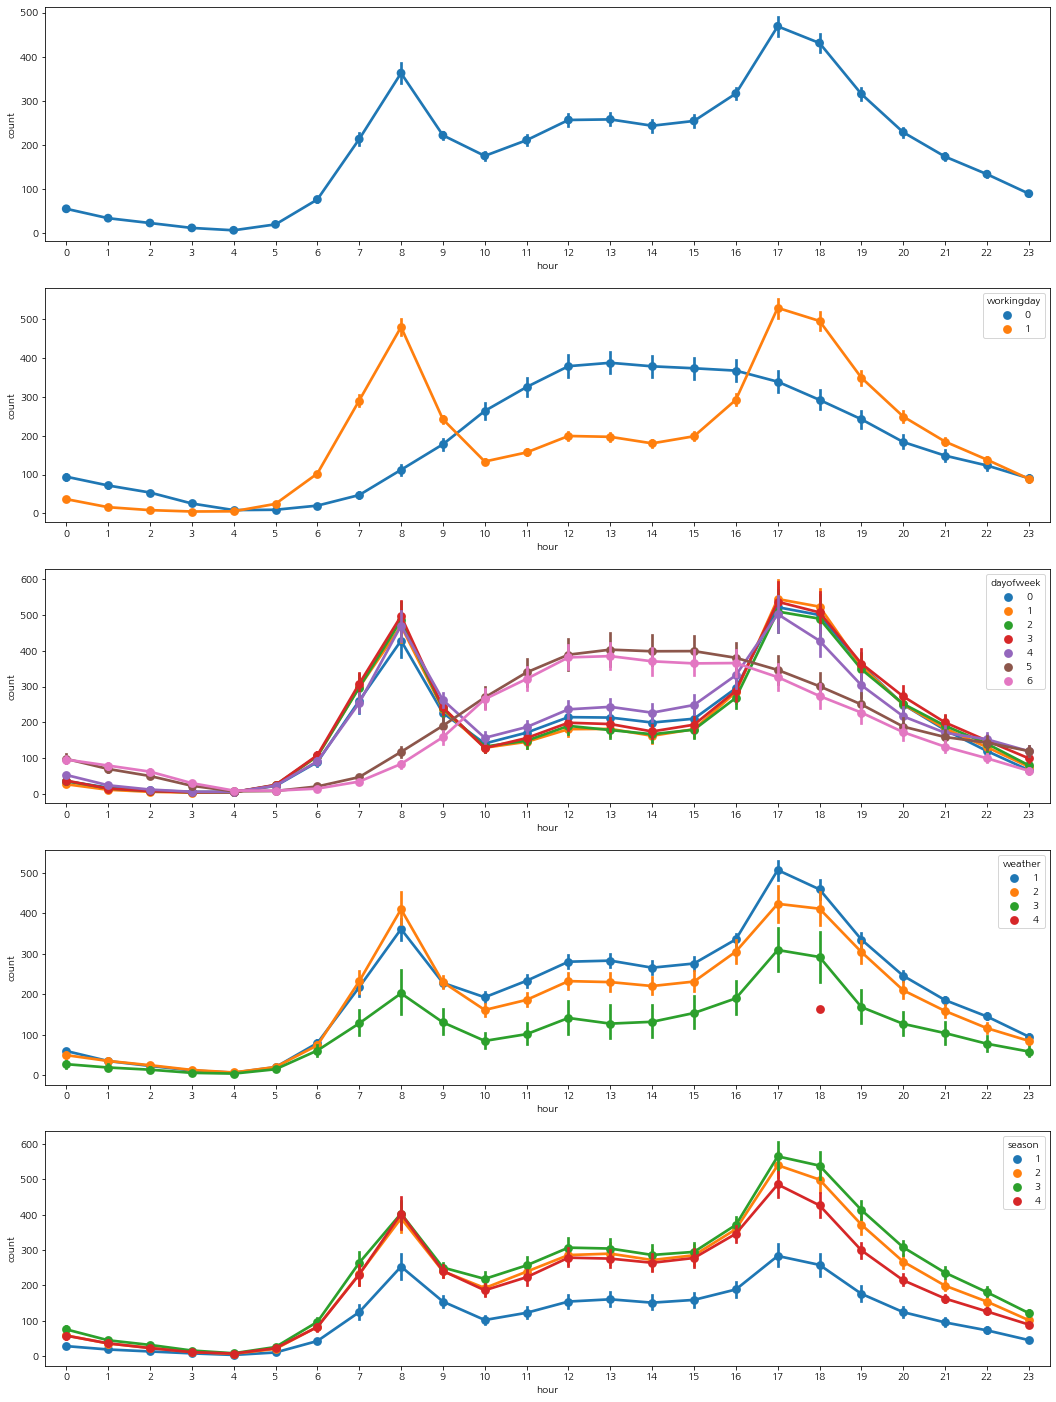

In [17]:
# pointplot 으로 시간대별, 대여량을 worjingday, datofweek, weather, season 별로 확인해보자.

fig,(ax1,ax2,ax3,ax4,ax5)= plt.subplots(nrows=5)
fig.set_size_inches(18,25)

sns.pointplot(data=train, x="hour", y="count", ax=ax1)

sns.pointplot(data=train, x="hour", y="count", hue="workingday", ax=ax2)

sns.pointplot(data=train, x="hour", y="count", hue="dayofweek", ax=ax3)

sns.pointplot(data=train, x="hour", y="count", hue="weather", ax=ax4)

sns.pointplot(data=train, x="hour", y="count", hue="season", ax=ax5)

- 시간대별로는 출퇴근 시간에 대여량이 많은 것을 알 수 있다.
- 휴일에는 점심시간에 전 후인 11시~17시까지 많은 것을 알 수 있다.
- datofweek에서 5,6은 토요일 일요일이다 , 나머지는 월~금 평일로 workingday와 비슷한 현상을 확인 할 수 있다.
- weather 날씨에 따라서는, 날씨가 좋을때는 대여량이 많고 날씨가 흐리고 안좋을때마다 적어짐을 확인 할 수 있다.
- season 계절에 따라서는 위에서 boxplot과 같이 봄(1),여름(2),가을(3),겨울(4) 인데, 가을 > 여름 > 겨울 > 봄 순으로 대여량이 많은것을 확인
할수 있다. 시간대 별로 본다면 역시 출,퇴근 시간에 가장 대여량이 많다.

temp, atemp, casual, registered, humidity, windspeed, count 의 관계성을 heatmap으로 시각화 해보자.

In [18]:
corrMatt = train[["temp", "atemp", "casual", "registered", "humidity", "windspeed", "count"]]
corrMatt = corrMatt.corr()
print(corrMatt)

mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False

                temp     atemp    casual  registered  humidity  windspeed  \
temp        1.000000  0.984948  0.467097    0.318571 -0.064949  -0.017852   
atemp       0.984948  1.000000  0.462067    0.314635 -0.043536  -0.057473   
casual      0.467097  0.462067  1.000000    0.497250 -0.348187   0.092276   
registered  0.318571  0.314635  0.497250    1.000000 -0.265458   0.091052   
humidity   -0.064949 -0.043536 -0.348187   -0.265458  1.000000  -0.318607   
windspeed  -0.017852 -0.057473  0.092276    0.091052 -0.318607   1.000000   
count       0.394454  0.389784  0.690414    0.970948 -0.317371   0.101369   

               count  
temp        0.394454  
atemp       0.389784  
casual      0.690414  
registered  0.970948  
humidity   -0.317371  
windspeed   0.101369  
count       1.000000  


<AxesSubplot:>

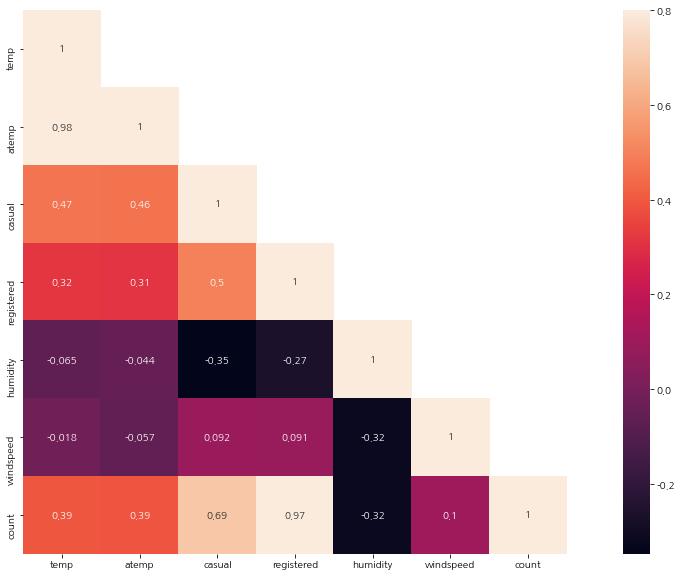

In [19]:
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

- 온도, 습도, 풍속은 거의 연관관계가 없다.
- 대여량과 가장 연관이 높은 건 registered 로 등록 된 대여자가 많지만, test 데이터에는 이 값이 없다. (따라서 피처로 사용하기에는 어렵다.)
- atemp와 temp는 0.98로 상관관계가 높지만 온도와 체감온도로 피처로 사용하기에 적합하지 않을 수 있다. ( 거의 같은 데이터로 보여진다.)

온도(temp), 풍속(windspeed), 습도(humidity) 에 따른 산점도를 그려보자.

<AxesSubplot:xlabel='humidity', ylabel='count'>

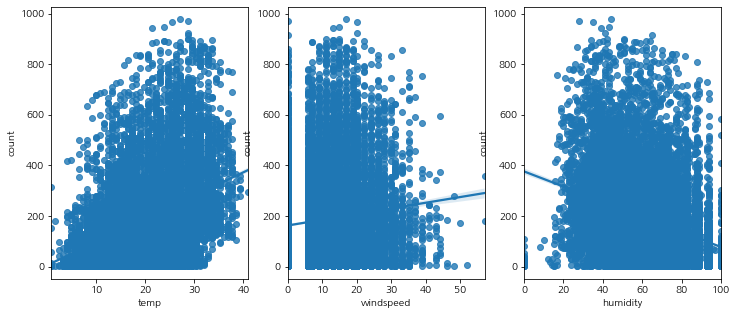

In [20]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 5)
sns.regplot(x="temp", y="count", data=train,ax=ax1)
sns.regplot(x="windspeed", y="count", data=train,ax=ax2)
sns.regplot(x="humidity", y="count", data=train,ax=ax3)

- 풍속(windspeed)의 경우 일부 데이터가  0에 몰려 있는 것이 확인 된다.(풍속 0에 몰려있는 데이터는 피처엔지니어링으로 조절할 필요가 있다.)
아마도 관측되지 않은 수치에 대해 0으로 기록된 것이 아닐까 추측해 본다.
- 습도(humidity)의 경우 일부 데이터가 0과 100에 몰려 있는 것이 확인 된다.

월별데이터로 모아보자

In [21]:
def concatenate_year_month(datetime):
    return "{0}-{1}".format(datetime.year, datetime.month) #연과 월을 붙여서 확인

train["year_month"] = train["datetime"].apply(concatenate_year_month)

print(train.shape)
train[["datetime", "year_month"]].head()

(10886, 20)


,datetime,year_month
0,2011-01-01 00:00:00,2011-1
1,2011-01-01 01:00:00,2011-1
2,2011-01-01 02:00:00,2011-1
3,2011-01-01 03:00:00,2011-1
4,2011-01-01 04:00:00,2011-1


<AxesSubplot:xlabel='year_month', ylabel='count'>

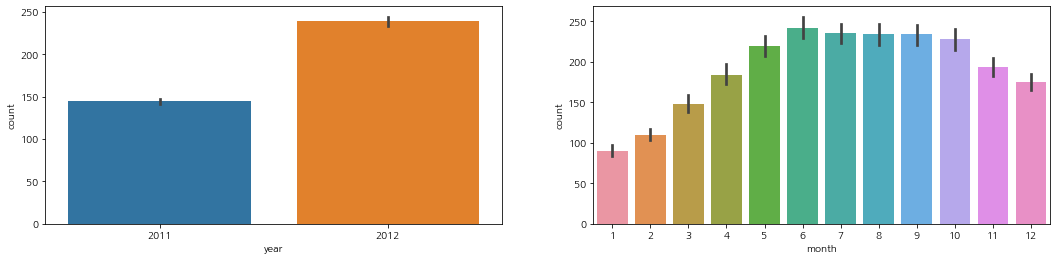

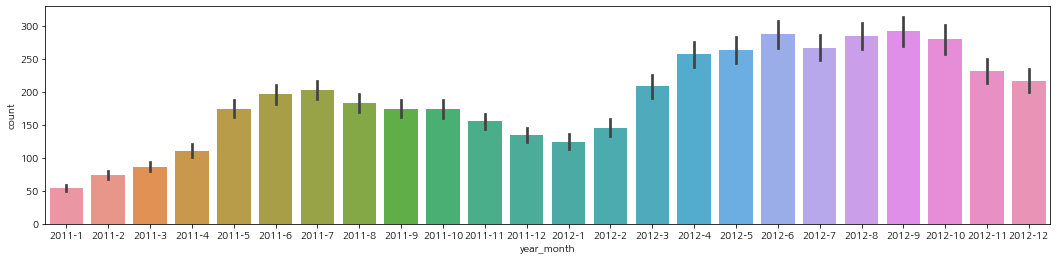

In [22]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(18, 4)

sns.barplot(data=train, x="year", y="count", ax=ax1)
sns.barplot(data=train, x="month", y="count", ax=ax2)

fig, ax3 = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(18, 4)

sns.barplot(data=train, x="year_month", y="count", ax=ax3)

- 2011년보다 2012년의 대여량이 더 많다.
- 겨울보다는 여름에 대여량이 많다.
- 2011년과 2012년의 월별 데이터를 이어보면 전체적으로 증가하는 추세이다.

Outlier 데이터를 제거하고 보려한다. 0과 100 이렇게 끝에 몰려 있던 데이터를 제거하려 한다.

In [23]:
# trainWithoutOutliers
trainWithoutOutliers = train[np.abs(train["count"] - train["count"].mean()) <= (3*train["count"].std())]

print(train.shape)
print(trainWithoutOutliers.shape)

(10886, 20)
(10739, 20)


- 약 10886에서 10739로 100여개 가량 줄였다.

제거한 데이터로 distplot, probplot로 그려봐서 제거 전과 비교 해 보자.

((array([-3.82819677, -3.60401975, -3.48099008, ...,  3.48099008,
          3.60401975,  3.82819677]),
  array([0.69314718, 0.69314718, 0.69314718, ..., 6.5971457 , 6.59850903,
         6.5998705 ])),
 (1.3486990121229776, 4.562423868087808, 0.9581176780909617))

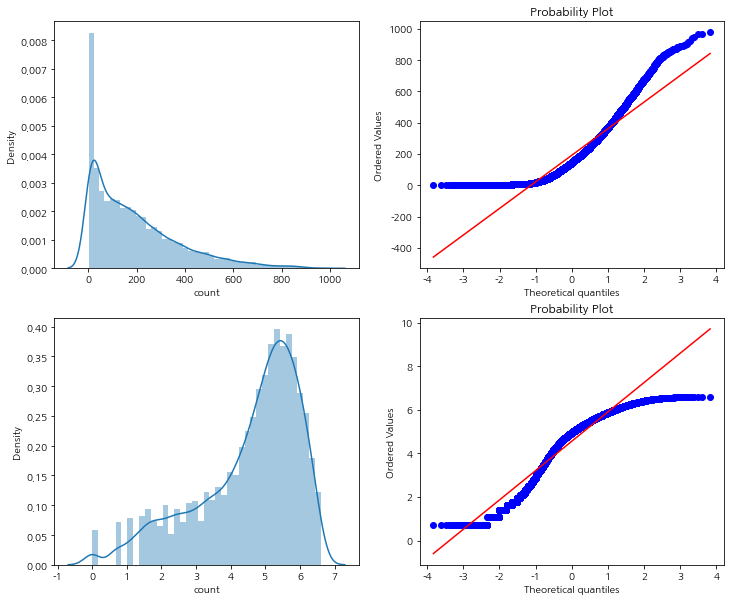

In [24]:
# count값의 데이터 분포도를 파악

figure, axes = plt.subplots(ncols=2, nrows=2)
figure.set_size_inches(12, 10)

sns.distplot(train["count"], ax=axes[0][0])
stats.probplot(train["count"], dist='norm', fit=True, plot=axes[0][1])
sns.distplot(np.log(trainWithoutOutliers["count"]), ax=axes[1][0])
stats.probplot(np.log1p(trainWithoutOutliers["count"]), dist='norm', fit=True, plot=axes[1][1])

- train["count"]을 보면 0에 굉장히 몰려있다.

- 0과 100에 치우쳐있던 데이터를 제거했지만, trainWithoutOutliers["count"]을 보면 아직 count변수가 오른쪽에 치우쳐져 있다. 대부분의 기계학습은 종속변수가 normal 이어야 하기에 정규분포를 갖는 것이 바람직하다. 대안으로 outlier data를 제거하고 "count"변수에 로그를 씌워 변경해 봐도 정규분포를 따르지는 않지만 이전 그래프보다는 좀 더 자세히 표현하고 있다.

#### Step3. Feature Engineering

In [25]:
# 판다스의 read_csv로 train.csv 파일 읽어오기

train = pd.read_csv('./kaggle_Bike Sharing Demand/train.csv',parse_dates=["datetime"])   # datetime형식으로 불러오기 parse_dates써서
test = pd.read_csv('./kaggle_Bike Sharing Demand/test.csv',parse_dates=["datetime"])

In [26]:
train.shape

(10886, 12)

- 12개의 columns 을 확인

In [27]:
test.shape

(6493, 9)

- 9개의 columns 을 확인

parse_dates로 불러온 train, test .  datetime을 세분화 하여 나누어 보자. 

In [28]:
train["year"] = train["datetime"].dt.year         # 년
train["month"] = train["datetime"].dt.month       # 월
train["day"] = train["datetime"].dt.day           # 일
train["hour"] = train["datetime"].dt.hour         # 시간
train["minute"] = train["datetime"].dt.minute     # 분
train["second"] = train["datetime"].dt.second     # 초
train["dayofweek"] = train["datetime"].dt.dayofweek     # 요일
train.shape

(10886, 19)

- 7개의 columns가 늘은 것을 확인 할 수 있다. (12에서 19로)

In [29]:
test["year"] = test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
test["day"] = test["datetime"].dt.day
test["hour"] = test["datetime"].dt.hour
test["minute"] = test["datetime"].dt.minute
test["second"] = test["datetime"].dt.second
test["dayofweek"] = test["datetime"].dt.dayofweek
test.shape

(6493, 16)

- 7개의 columns가 늘은 것을 확인 할 수 있다. (9에서 16으로)

풍속을 시각화 해보자.

<AxesSubplot:title={'center':'test windspeed'}, xlabel='windspeed', ylabel='count'>

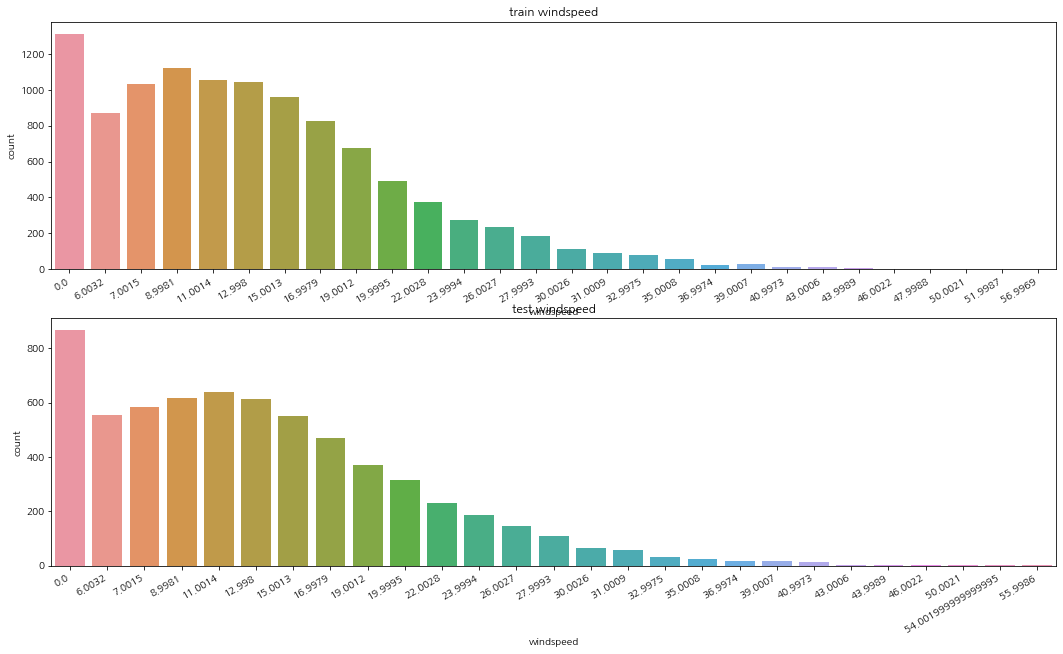

In [30]:
# widspeed 풍속에 0 값이 가장 많다. => 잘못 기록된 데이터를 고쳐 줄 필요가 있음
fig, axes = plt.subplots(nrows=2)
fig.set_size_inches(18,10)

plt.sca(axes[0])
plt.xticks(rotation=30, ha='right')
axes[0].set(ylabel='Count',title="train windspeed")
sns.countplot(data=train, x="windspeed", ax=axes[0])

plt.sca(axes[1])
plt.xticks(rotation=30, ha='right')
axes[1].set(ylabel='Count',title="test windspeed")
sns.countplot(data=test, x="windspeed", ax=axes[1])

In [31]:
# 풍속의 0값에 특정 값을 넣어준다.
# 평균을 구해 일괄적으로 넣어줄 수도 있지만, 예측의 정확도를 높이는 데 도움이 될것 같진 않다.
# train.loc[train["windspeed"] == 0, "windspeed"] = train["windspeed"].mean()
# test.loc[train["windspeed"] == 0, "windspeed"] = train["windspeed"].mean()

In [32]:
# 풍속이 0인것과 아닌 것의 세트를 나누어 준다.
trainWind0 = train.loc[train['windspeed'] == 0]
trainWindNot0 = train.loc[train['windspeed'] != 0]
print(trainWind0.shape)
print(trainWindNot0.shape)

(1313, 19)
(9573, 19)


- 풍속이 0인것이 1313개로 확인

풍속이 0인 것을(결측치로보고) 머신러닝으로 예측을 해서 풍속을 넣어 준다.

In [33]:
# 그래서 머신러닝으로 예측을 해서 풍속을 넣어주도록 한다.
from sklearn.ensemble import RandomForestClassifier

def predict_windspeed(data):
    
    # 풍속이 0인것과 아닌 것을 나누어 준다.
    dataWind0 = data.loc[data['windspeed'] == 0]
    dataWindNot0 = data.loc[data['windspeed'] != 0]
    
    # 풍속을 예측할 피처를 선택한다.
    wCol = ["season", "weather", "humidity", "month", "temp", "year", "atemp"]

    # 풍속이 0이 아닌 데이터들의 타입을 스트링으로 바꿔준다.
    dataWindNot0["windspeed"] = dataWindNot0["windspeed"].astype("str")

    # 랜덤포레스트 분류기를 사용한다.
    rfModel_wind = RandomForestClassifier()

    # wCol에 있는 피처의 값을 바탕으로 풍속을 학습시킨다.
    rfModel_wind.fit(dataWindNot0[wCol], dataWindNot0["windspeed"])

    # 학습한 값을 바탕으로 풍속이 0으로 기록 된 데이터의 풍속을 예측한다.
    wind0Values = rfModel_wind.predict(X = dataWind0[wCol])

    # 값을 다 예측 후 비교해 보기 위해
    # 예측한 값을 넣어 줄 데이터 프레임을 새로 만든다.
    predictWind0 = dataWind0
    predictWindNot0 = dataWindNot0

    # 값이 0으로 기록 된 풍속에 대해 예측한 값을 넣어준다.
    predictWind0["windspeed"] = wind0Values

    # dataWindNot0 0이 아닌 풍속이 있는 데이터프레임에 예측한 값이 있는 데이터프레임을 합쳐준다.
    data = predictWindNot0.append(predictWind0)

    # 풍속의 데이터타입을 float으로 지정해 준다.
    data["windspeed"] = data["windspeed"].astype("float")

    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)
    
    return data

<AxesSubplot:title={'center':'train windspeed'}, xlabel='windspeed', ylabel='count'>

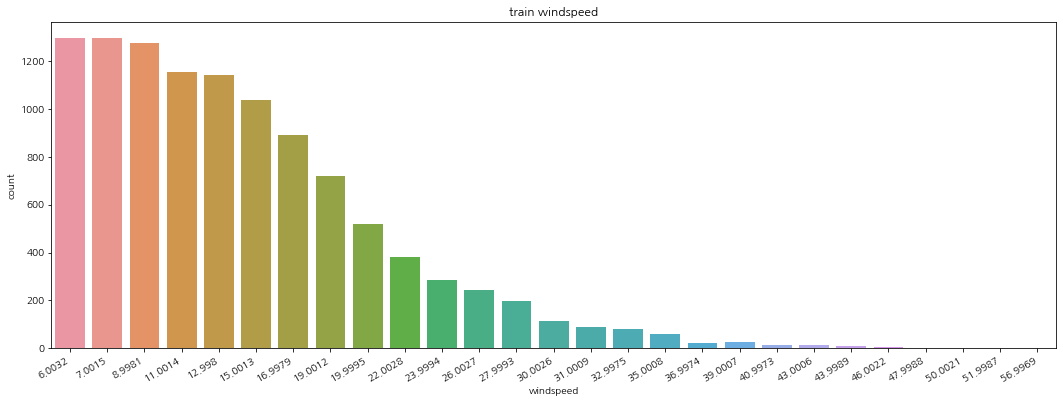

In [34]:
# 0값을 조정한다.
train = predict_windspeed(train)
# test = predict_windspeed(test)

# widspeed 의 0값을 조정한 데이터를 시각화
fig, ax1 = plt.subplots()
fig.set_size_inches(18,6)

plt.sca(ax1)
plt.xticks(rotation=30, ha='right')  # x축 글자를 30도 틀어서 글자가 겹치는 것을 방지한다.
ax1.set(ylabel='Count',title="train windspeed")
sns.countplot(data=train, x="windspeed", ax=ax1)

- 0인 값을 렌덤포레스트로 예측된 값을 넣어 주었다. 0인 데이터가 없어졌음을 확인 할 수 있다.

#### Step4. Feature Selection  (피처 선택)

- 신호와 잡음을 구분해야 한다.
- 피처가 많다고 해서 무조건 좋은 성능을 내지 않는다.(과적합)
- 피처를 하나씩 추가하고 변경해 가면서 성능이 좋지 않은 피처는 제거하도록 한다.

연속형 피처는 온도, 습도, 풍속은 숫자의 크기에 따라 높고 낮음(강약 등 크기 등)을 알 수 있지만, 범주형 피처는 요일,계절등을 0,1,2,3으로
나타낸 것이기 때문에 원-핫 코딩으로 바꿔줄 필요가 있다. 여기서는 범주형 피처를 카테고리를 통해 바꿔주기로 했다.

In [35]:
# 연속형 feature와 범주형 feature 
# 연속형 feature = ["temp","humidity","windspeed","atemp"]
# 범주형 feature의 type을 category로 변경 해 준다.
categorical_feature_names = ["season","holiday","workingday","weather",
                             "dayofweek","month","year","hour"]

for var in categorical_feature_names:
    train[var] = train[var].astype("category")
    test[var] = test[var].astype("category")

In [36]:
feature_names = ["season", "weather", "temp", "atemp", "humidity", "windspeed",
                 "year", "hour", "dayofweek", "holiday", "workingday"]

feature_names

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'year',
 'hour',
 'dayofweek',
 'holiday',
 'workingday']

In [37]:
X_train = train[feature_names]

print(X_train.shape)
X_train.head()

(10886, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,2,9.84,12.880,75,6.0032,2011,5,5,0,0
1,1,1,15.58,19.695,76,16.9979,2011,10,5,0,0
2,1,1,14.76,16.665,81,19.0012,2011,11,5,0,0
3,1,1,17.22,21.210,77,19.0012,2011,12,5,0,0
4,1,2,18.86,22.725,72,19.9995,2011,13,5,0,0


In [38]:
X_test = test[feature_names]

print(X_test.shape)
X_test.head()

(6493, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,11.365,56,26.0027,2011,0,3,0,1
1,1,1,10.66,13.635,56,0.0000,2011,1,3,0,1
2,1,1,10.66,13.635,56,0.0000,2011,2,3,0,1
3,1,1,10.66,12.880,56,11.0014,2011,3,3,0,1
4,1,1,10.66,12.880,56,11.0014,2011,4,3,0,1


In [39]:
label_name = "count"

y_train = train[label_name]

print(y_train.shape)
y_train.head()

(10886,)


0     1
1    36
2    56
3    84
4    94
Name: count, dtype: int64

### Step5 . Score
#### RMSLE

In [40]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values):
    # 넘파이로 배열 형태로 바꿔준다.
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    # 예측값과 실제 값에 1을 더하고 로그를 씌워준다.
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    # 위에서 계산한 예측값에서 실제값을 빼주고 제곱을 해준다.
    difference = log_predict - log_actual
    # difference = (log_predict - log_actual) ** 2
    difference = np.square(difference)
    
    # 평균을 낸다.
    mean_difference = difference.mean()
    
    # 다시 루트를 씌운다.
    score = np.sqrt(mean_difference)
    
    return score

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

### Cross Validation 교차 검증

일반화 성능을 측정하기 위해 데이터를 여러 번 반복해서 나누고 여러 모델을 학습한다.

KFold 교차검증
- 데이터를 폴드라 부르는 비슷한 크기의 부분집합(n_splits)으로 나누고 각각의 폴드 정확도를 측정한다.
- 첫 번째 폴드를 테스트 세트로 사용하고 나머지 폴드를 훈련세트로 사용하여 학습한다.
- 나머지 훈련세트로 만들어진 세트의 정확도를 첫 번째 폴드로 평가한다.
- 다음은 두 번째 폴드가 테스트 세트가 되고 나머지 폴드의 훈련세트를 두 번째 폴드로 정확도를 측정한다.
- 이 과정을 마지막 폴드까지 반복한다.
- 이렇게 훈련세트와 테스트세트로 나누는 N개의 분할마다 정확도를 측정하여 평균 값을 낸게 정확도가 된다.

In [75]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

### RandomForest

n_estimators 값 높이면 시간이 오래걸리기 때문에 100으로 초기화하고 진행한다. 

In [76]:
from sklearn.ensemble import RandomForestRegressor

max_depth_list = []

model = RandomForestRegressor(n_estimators=100,
                              n_jobs=-1,
                              random_state=0)
model

RandomForestRegressor(n_jobs=-1, random_state=0)

In [77]:
%time score = cross_val_score(model, X_train, y_train, cv=k_fold, scoring=rmsle_scorer)
score = score.mean()
# 0에 근접할수록 좋은 데이터
print("Score= {0:.5f}".format(score))

CPU times: user 2.38 s, sys: 398 ms, total: 2.78 s
Wall time: 18.9 s
Score= 0.33057


점수는 0.33057이 나왔다. 0에 근접할수록 좋은 데이터이다.

### Train

In [78]:
# 학습시킴, 피팅(옷을 맞출 때 사용하는 피팅을 생각함) - 피처와 레이블을 넣어주면 알아서 학습을 함
model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=0)

In [79]:
# 예측
predictions = model.predict(X_test)

print(predictions.shape)
predictions[0:10]

(6493,)


array([ 12.56,   5.11,   4.32,   3.54,   3.18,   6.41,  37.93, 105.02,
       236.33, 136.43])

[Text(0.5, 1.0, 'test')]

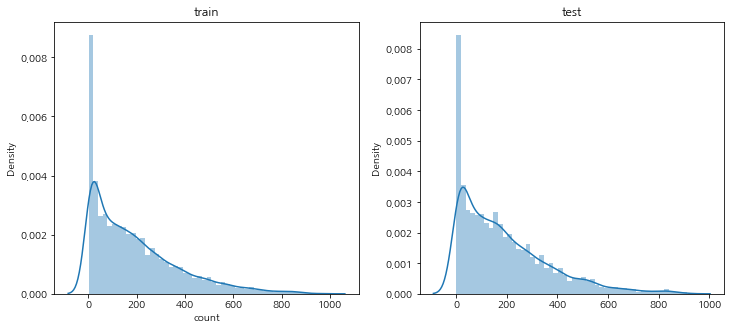

In [80]:
# 예측한 데이터를 시각화 해본다. 
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1,bins=50)
ax1.set(title="train")
sns.distplot(predictions,ax=ax2,bins=50)
ax2.set(title="test")

#### Step6. Submit

캐글에 제출을 해보자.

In [85]:

submission = pd.read_csv("./kaggle_Bike Sharing Demand/sampleSubmission.csv")
submission

submission["count"] = predictions

print(submission.shape)
submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,12.56
1,2011-01-20 01:00:00,5.11
2,2011-01-20 02:00:00,4.32
3,2011-01-20 03:00:00,3.54
4,2011-01-20 04:00:00,3.18


In [86]:
submission.to_csv("./kaggle_Bike Sharing Demand/Score_{0:.5f}_submission.csv".format(score), index=False)

<center>
<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FdpSRbf%2Fbtq5uuptG93%2FnmfSQnT5ywwpvcnHPD8GL0%2Fimg.png"><br>
</center>


0.41848 이라는 점수가 나왔다. 우월하다는 XGBoost 를 써서 한번 더 도전 해보려 한다.  총평은 XGBoost를 사용해보고 남겨야겠다.